# Identification of Quality Models from data

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import sys



sys.path.append('E:/GitHub/DigitalTwinInjectionMolding/')
sys.path.append('/home/alexander/GitHub/DigitalTwinInjectionMolding/')


from DIM.miscellaneous.PreProcessing import arrange_data_for_qual_ident

from DIM.models.model_structures import GRU
from DIM.models.injection_molding import QualityModel
from DIM.optim.param_optim import ModelTraining

Load historical data to use for model estimation

In [2]:
cycles = []

for i in range(1,11):
    cycles.append(pkl.load(open('../data/Versuchsplan/cycle'+str(i)+'.pkl','rb')))

cycles_train = cycles[2:7]
cycles_val = cycles[8:10]

In [3]:
print(cycles[0])

           Q_Vol_ist  V_Screw_ist  p_wkz_ist  T_wkz_ist   p_inj_soll  \
0.000000    0.000000    26.072977        0.0  46.494946     0.000000   
0.020000    0.000000    26.078669        0.0  46.273685  2000.026855   
0.040000   10.669321    25.637669        0.0  46.273685  2000.026855   
0.060000   38.694073    24.599188        0.0  46.426281  2000.026855   
0.080000   58.041107    23.432676        0.0  46.266056  2000.026855   
...              ...          ...        ...        ...          ...   
24.059999        NaN          NaN        0.0  51.507610     0.000000   
24.079999        NaN          NaN        0.0  51.408424     0.000000   
24.099999        NaN          NaN        0.0  51.400795     0.000000   
24.119999        NaN          NaN        0.0  51.309242     0.000000   
24.139999        NaN          NaN        0.0  51.232944     0.000000   

            p_inj_ist  Q_inj_soll  T_zyl1_ist  T_zyl2_ist  T_zyl3_ist  ...  \
0.000000   -12.940154        48.0  229.699997       235.0

Select process variables and quality measurements for modelling

In [4]:
q_lab = ['Durchmesser_innen']
x_lab= ['p_wkz_ist','T_wkz_ist','p_inj_ist','Q_Vol_ist','V_Screw_ist']

In [5]:
x_train,q_train,switch_train = arrange_data_for_qual_ident(cycles_train,x_lab,q_lab)
x_val,q_val,switch_val = arrange_data_for_qual_ident(cycles_val,x_lab,q_lab)

Plot training data

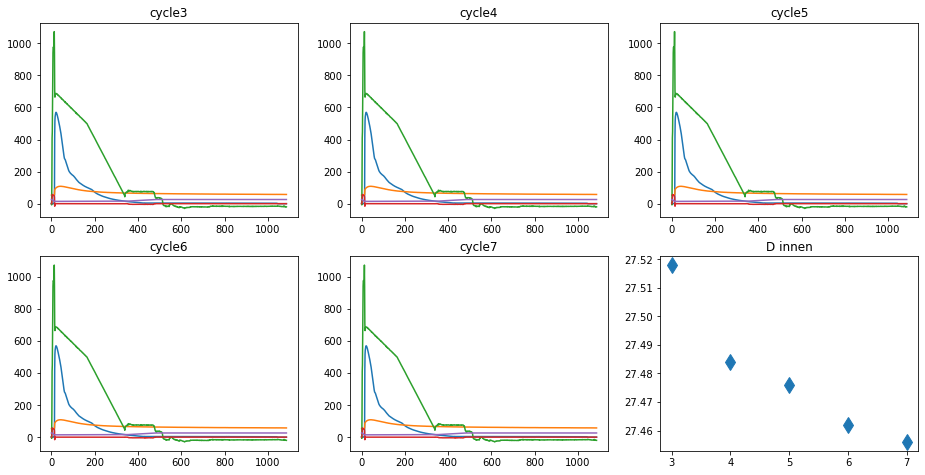

In [6]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches((40/2.54,20/2.54))
plt.subplot(2,3,1,title='cycle3');plt.plot(x_train[0])
plt.subplot(2,3,2,title='cycle4');plt.plot(x_train[0])
plt.subplot(2,3,3,title='cycle5');plt.plot(x_train[0])
plt.subplot(2,3,4,title='cycle6');plt.plot(x_train[0])
plt.subplot(2,3,5,title='cycle7');plt.plot(x_train[0])
plt.subplot(2,3,6,title='D innen');plt.plot([3,4,5,6,7],q_train,'d',markersize=12)

Initialize Quality Model, comprising one model for the injection, pressure and cooling phase, respectively

In [7]:
dim_c = 2

injection_model = GRU(dim_u=5,dim_c=dim_c,dim_hidden=10,dim_out=1,name='inject')
press_model = GRU(dim_u=5,dim_c=dim_c,dim_hidden=10,dim_out=1,name='press')
cool_model = GRU(dim_u=5,dim_c=dim_c,dim_hidden=10,dim_out=1,name='cool')

quality_model = QualityModel(subsystems=[injection_model,press_model,cool_model],
                              name='q_model')

In [8]:
c0_train = [np.zeros((dim_c,1)) for i in range(0,len(x_train))]
c0_val = [np.zeros((dim_c,1)) for i in range(0,len(x_val))]

data = {'u_train': x_train,
        'y_train': q_train,
        'switch_train': switch_train,
        'init_state_train': c0_train,
        'u_val': x_val,
        'y_val': q_val,
        'switch_val': switch_val,
        'init_state_val': c0_val}

Usually the model and the data is given to the ModelTraining() procedure, to estimate the optimal parameters, this has been done in advance so the results are merely loaded

In [9]:
# results = ModelTraining(quality_model,data,initializations=10, BFR=False, 
#                   p_opts=None, s_opts=None)
results = pkl.load(open('../QualityModel_GRU_1c_5in_1out.pkl','rb'))
print(results)

                  loss_val    model  initialization  \
0  [0.0008424807441577314]  q_model               0   
1  [0.0012400400005189516]  q_model               1   
2  [0.0001160887472134536]  q_model               2   
3  [6.850712317395293e-05]  q_model               3   
4  [8.771111905447272e-05]  q_model               4   
5  [0.0012400399958560895]  q_model               5   
6   [0.011738284559765874]  q_model               6   
7  [0.0012400391825351188]  q_model               7   
8  [0.0012400398122088332]  q_model               8   
9  [0.0012400399711116337]  q_model               9   

                                              params  
0  {'W_r_inject': [[0.24235582417854262, 0.125066...  
1  {'W_r_inject': [[0.8070581615219834, 0.9162078...  
2  {'W_r_inject': [[0.9155339597978553, 0.7010195...  
3  {'W_r_inject': [[0.07434528471796653, 0.143568...  
4  {'W_r_inject': [[0.6979409445869403, 0.5223945...  
5  {'W_r_inject': [[0.730022861779907, 0.28025613...  
6  {'W_r_

The parameters the led to the best results on the validation dataset (row index 3) are assigned to the quality model

In [10]:
quality_model.AssignParameters(results.loc[3,'params'])

In [11]:

_,y_val0 = quality_model.Simulation(data['init_state_val'][0], data['u_val'][0],None,data['switch_val'][0])
_,y_val1 = quality_model.Simulation(data['init_state_val'][0], data['u_val'][1],None,data['switch_val'][1])

y_val0 = np.array(y_val0[-1])[0]
y_val1 = np.array(y_val1[-1])[0]

Plot input validation data as well as predicted and true output data

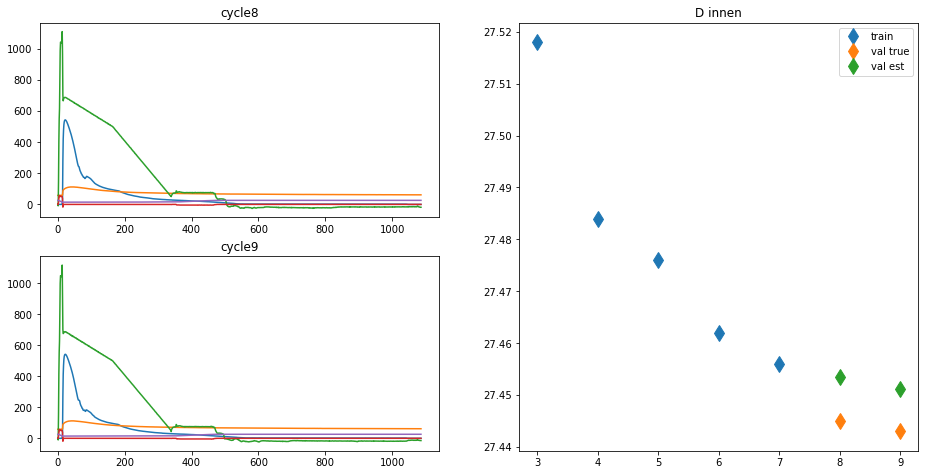

In [14]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches((40/2.54,20/2.54))
plt.subplot(2,2,1,title='cycle8');plt.plot(x_val[0])
plt.subplot(2,2,3,title='cycle9');plt.plot(x_val[1])
plt.subplot(1,2,2,title='D innen')
plt.plot([3,4,5,6,7],q_train,'d',markersize=12,label='train')
plt.plot([8,9],q_val,'d',markersize=12,label='val true')
plt.plot([8,9],[y_val0,y_val1],'d',markersize=12,label='val est');plt.legend()

I.e. the model overestimates the true quality measurement "D innen" 